# Shopping Traffic Patterns: Days and Times Analysis

This notebook analyzes when customers shop most frequently by examining traffic patterns across days of the week and times of day.

## Setup and Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from completejourney_py import get_data

# Set plotting style
plt.style.use('default')
sns.set_palette("viridis")

In [2]:
# Load transactions data
data = get_data(["transactions"])
transactions = data["transactions"]

print(f"Loaded {len(transactions):,} transaction records")
print(f"Available columns: {list(transactions.columns)}")
print(f"Date range: {transactions['transaction_timestamp'].dt.date.min()} to {transactions['transaction_timestamp'].dt.date.max()}")
print(f"Week range: Week {transactions['week'].min()} to Week {transactions['week'].max()}")

Loaded 1,469,307 transaction records
Available columns: ['household_id', 'store_id', 'basket_id', 'product_id', 'quantity', 'sales_value', 'retail_disc', 'coupon_disc', 'coupon_match_disc', 'week', 'transaction_timestamp']
Date range: 2017-01-01 to 2018-01-01
Week range: Week 1 to Week 53


## Data Preparation: Create Time Features

In [3]:
# Extract date and time features from transaction_timestamp
transactions['date'] = transactions['transaction_timestamp'].dt.date
transactions['hour_of_day'] = transactions['transaction_timestamp'].dt.hour
transactions['day_of_week'] = transactions['transaction_timestamp'].dt.dayofweek + 1  # Monday=1, Sunday=7

# Create shopping trip dataset (one record per basket)
shopping_trips = (
    transactions
    .groupby(['basket_id', 'date', 'hour_of_day', 'day_of_week', 'week', 'household_id'])
    .agg({
        'sales_value': 'sum',
        'quantity': 'sum',
        'product_id': 'nunique'
    })
    .reset_index()
    .rename(columns={
        'sales_value': 'trip_value',
        'quantity': 'total_items', 
        'product_id': 'unique_products'
    })
)

print(f"Total shopping trips: {len(shopping_trips):,}")

# Create day name mapping
day_names = {1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday', 7: 'Sunday'}
shopping_trips['day_name'] = shopping_trips['day_of_week'].map(day_names)

# Create time of day categories
def categorize_time_of_day(hour):
    if 6 <= hour < 12:
        return 'Morning (6-12)'
    elif 12 <= hour < 17:
        return 'Afternoon (12-17)'
    elif 17 <= hour < 21:
        return 'Evening (17-21)'
    else:
        return 'Night/Early (21-6)'

shopping_trips['time_category'] = shopping_trips['hour_of_day'].apply(categorize_time_of_day)

print(f"Hour range: {shopping_trips['hour_of_day'].min()} to {shopping_trips['hour_of_day'].max()}")
print(f"Date range: {shopping_trips['date'].min()} to {shopping_trips['date'].max()}")

Total shopping trips: 155,848
Hour range: 0 to 23
Date range: 2017-01-01 to 2018-01-01


## Day of Week Traffic Analysis

In [4]:
# Analyze traffic by day of week
daily_traffic = (
    shopping_trips['day_name']
    .value_counts()
    .reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
)

# Calculate percentages
daily_traffic_pct = (daily_traffic / daily_traffic.sum() * 100).round(1)

print("Shopping Traffic by Day of Week:")
print("=" * 40)
for day, count in daily_traffic.items():
    pct = daily_traffic_pct[day]
    print(f"{day:10s}: {count:6,} trips ({pct:4.1f}%)")

# Find peak and low traffic days
peak_day = daily_traffic.idxmax()
low_day = daily_traffic.idxmin()
print(f"\nPeak traffic day: {peak_day} ({daily_traffic[peak_day]:,} trips)")
print(f"Lowest traffic day: {low_day} ({daily_traffic[low_day]:,} trips)")

Shopping Traffic by Day of Week:
Monday    : 21,561 trips (13.8%)
Tuesday   : 20,997 trips (13.5%)
Wednesday : 20,431 trips (13.1%)
Thursday  : 21,006 trips (13.5%)
Friday    : 21,081 trips (13.5%)
Saturday  : 24,842 trips (15.9%)
Sunday    : 25,930 trips (16.6%)

Peak traffic day: Sunday (25,930 trips)
Lowest traffic day: Wednesday (20,431 trips)


## Time of Day Traffic Analysis

In [5]:
# Analyze traffic by hour of day
hourly_traffic = shopping_trips['hour_of_day'].value_counts().sort_index()

# Analyze by time categories
time_category_traffic = shopping_trips['time_category'].value_counts()
time_category_pct = (time_category_traffic / time_category_traffic.sum() * 100).round(1)

print("Shopping Traffic by Time of Day:")
print("=" * 35)
for category, count in time_category_traffic.items():
    pct = time_category_pct[category]
    print(f"{category:20s}: {count:6,} trips ({pct:4.1f}%)")

# Find peak hours
peak_hour = hourly_traffic.idxmax()
print(f"\nPeak hour: {peak_hour}:00 ({hourly_traffic[peak_hour]:,} trips)")
print(f"Top 3 busiest hours: {hourly_traffic.nlargest(3).index.tolist()}")

Shopping Traffic by Time of Day:
Night/Early (21-6)  : 73,490 trips (47.2%)
Evening (17-21)     : 46,286 trips (29.7%)
Afternoon (12-17)   : 31,805 trips (20.4%)
Morning (6-12)      :  4,267 trips ( 2.7%)

Peak hour: 22:00 (15,106 trips)
Top 3 busiest hours: [22, 21, 23]


## Visualization: Daily Traffic Patterns

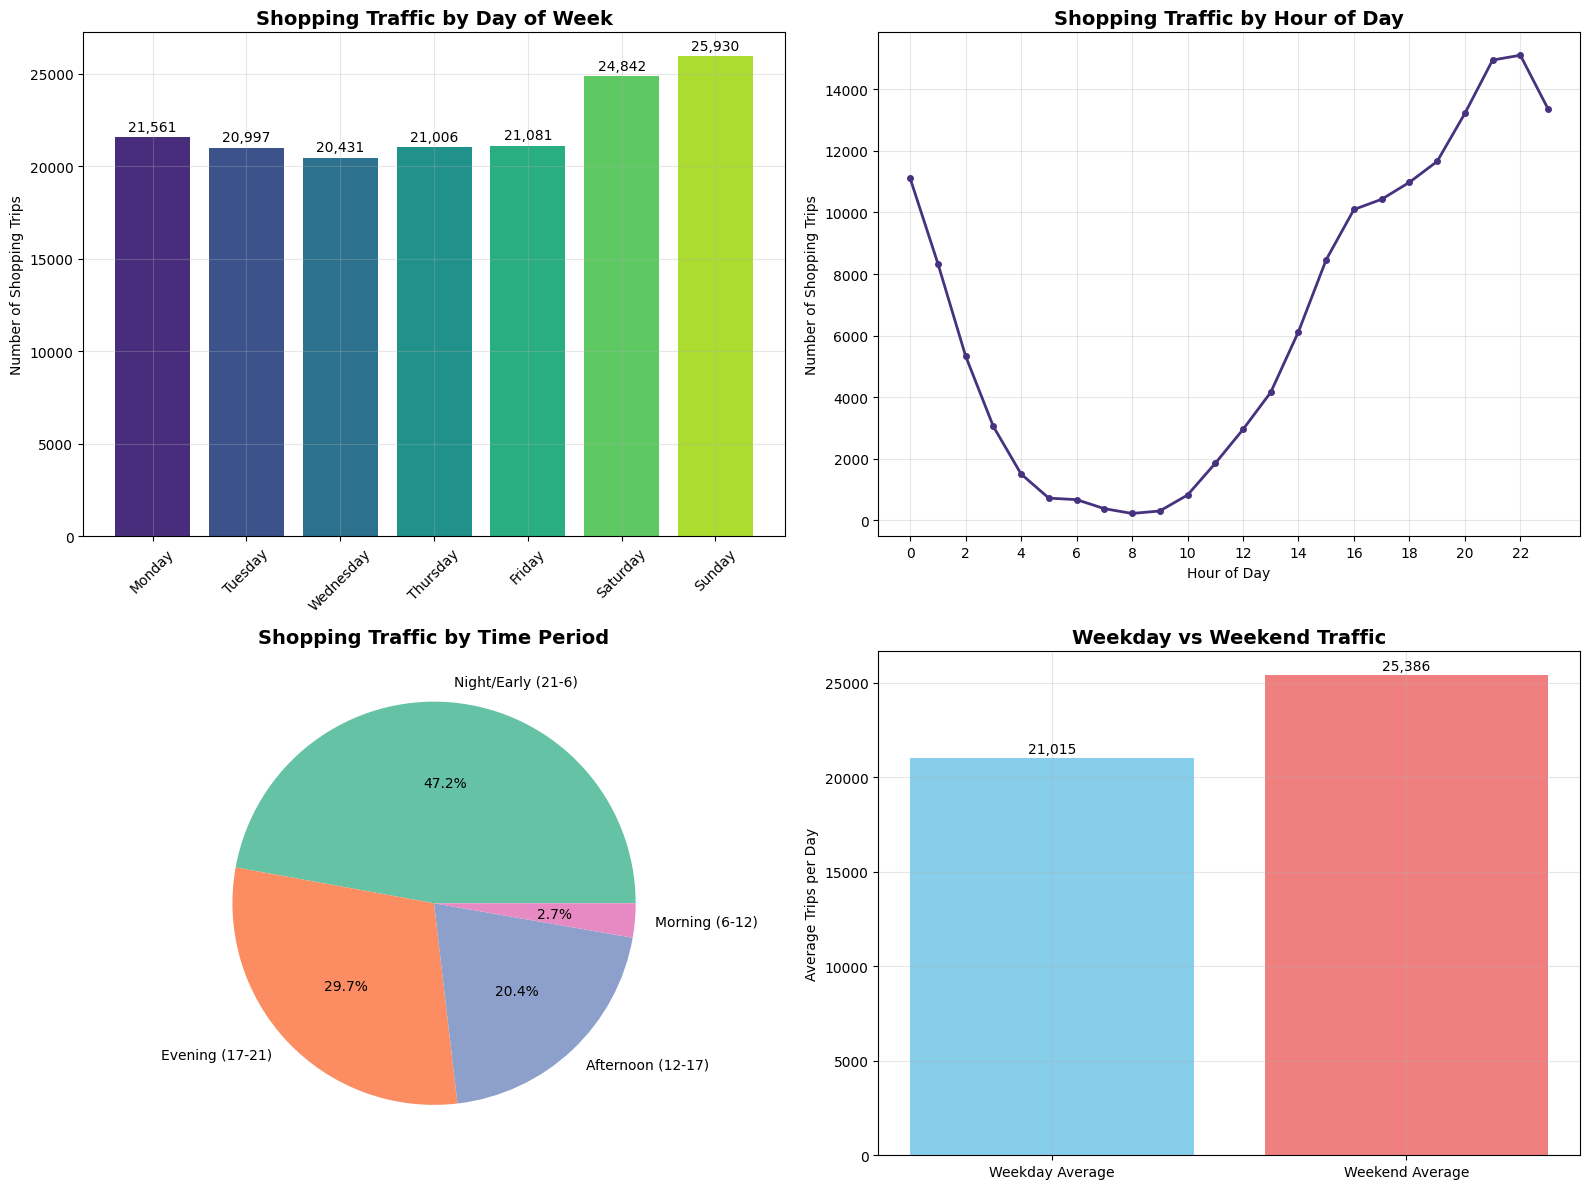


Weekday vs Weekend Comparison:
Average weekday traffic: 21,015 trips/day
Average weekend traffic: 25,386 trips/day
Weekend vs Weekday ratio: 1.21x


In [6]:
# Create comprehensive traffic visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Day of week bar chart
colors_daily = sns.color_palette("viridis", 7)
bars1 = ax1.bar(daily_traffic.index, daily_traffic.values, color=colors_daily)
ax1.set_ylabel('Number of Shopping Trips')
ax1.set_title('Shopping Traffic by Day of Week', fontsize=14, fontweight='bold')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 200,
            f'{height:,.0f}', ha='center', va='bottom')

# Hourly traffic line chart
ax2.plot(hourly_traffic.index, hourly_traffic.values, marker='o', linewidth=2, markersize=4)
ax2.set_xlabel('Hour of Day')
ax2.set_ylabel('Number of Shopping Trips')
ax2.set_title('Shopping Traffic by Hour of Day', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_xticks(range(0, 24, 2))

# Time category pie chart
colors_time = sns.color_palette("Set2", len(time_category_traffic))
wedges, texts, autotexts = ax3.pie(time_category_traffic.values, labels=time_category_traffic.index, 
                                  autopct='%1.1f%%', colors=colors_time)
ax3.set_title('Shopping Traffic by Time Period', fontsize=14, fontweight='bold')

# Weekend vs Weekday comparison
weekend_days = ['Saturday', 'Sunday']
weekday_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

weekend_traffic = daily_traffic[weekend_days].sum()
weekday_traffic = daily_traffic[weekday_days].sum()

weekend_avg = weekend_traffic / 2  # 2 weekend days
weekday_avg = weekday_traffic / 5  # 5 weekdays

comparison_data = [weekday_avg, weekend_avg]
comparison_labels = ['Weekday Average', 'Weekend Average']

bars4 = ax4.bar(comparison_labels, comparison_data, color=['skyblue', 'lightcoral'])
ax4.set_ylabel('Average Trips per Day')
ax4.set_title('Weekday vs Weekend Traffic', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3)

# Add value labels
for bar in bars4:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 100,
            f'{height:,.0f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print(f"\nWeekday vs Weekend Comparison:")
print(f"Average weekday traffic: {weekday_avg:,.0f} trips/day")
print(f"Average weekend traffic: {weekend_avg:,.0f} trips/day")
print(f"Weekend vs Weekday ratio: {weekend_avg/weekday_avg:.2f}x")

## Heatmap: Day and Time Combined Analysis

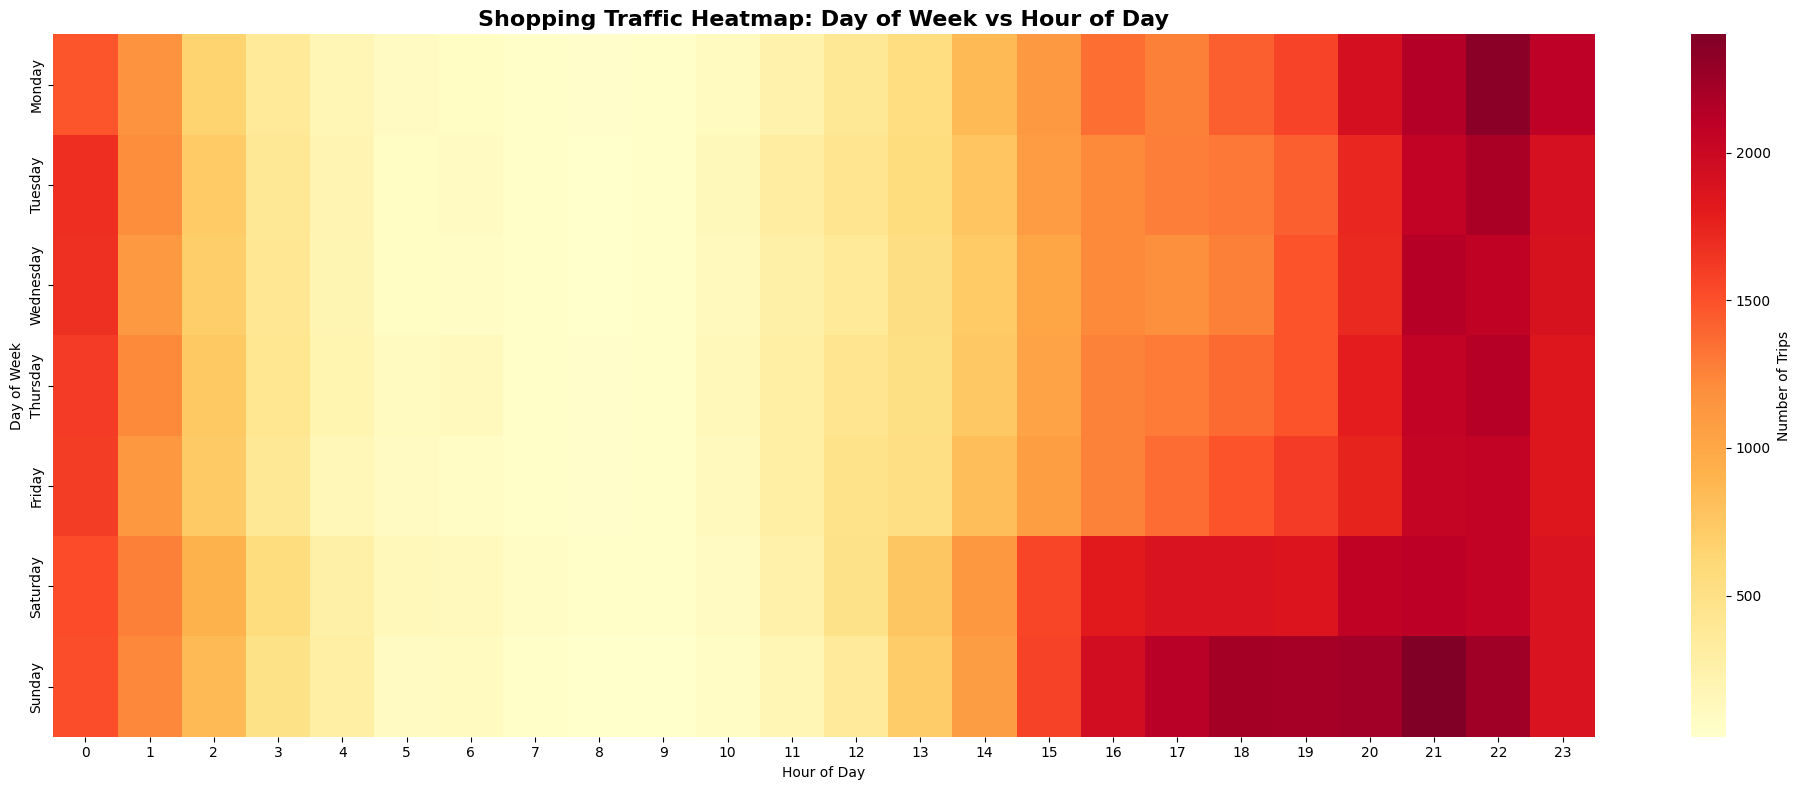


Top 10 Busiest Day-Hour Combinations:
 1. Sunday at 21:00 - 2,401 trips
 2. Monday at 22:00 - 2,343 trips
 3. Sunday at 22:00 - 2,238 trips
 4. Sunday at 20:00 - 2,226 trips
 5. Sunday at 18:00 - 2,220 trips
 6. Sunday at 19:00 - 2,207 trips
 7. Tuesday at 22:00 - 2,193 trips
 8. Monday at 21:00 - 2,148 trips
 9. Wednesday at 21:00 - 2,136 trips
10. Thursday at 22:00 - 2,129 trips


In [7]:
# Create heatmap of traffic by day and hour
traffic_heatmap_data = (
    shopping_trips
    .groupby(['day_name', 'hour_of_day'])
    .size()
    .reset_index(name='trip_count')
)

# Pivot for heatmap
heatmap_pivot = traffic_heatmap_data.pivot(index='day_name', columns='hour_of_day', values='trip_count').fillna(0)

# Reorder days
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_pivot = heatmap_pivot.reindex(day_order)

# Create heatmap
fig, ax = plt.subplots(figsize=(20, 8))
sns.heatmap(heatmap_pivot, annot=False, cmap='YlOrRd', cbar_kws={'label': 'Number of Trips'}, ax=ax)
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Day of Week')
ax.set_title('Shopping Traffic Heatmap: Day of Week vs Hour of Day', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

# Find peak traffic combinations
peak_combinations = (
    traffic_heatmap_data
    .nlargest(10, 'trip_count')
    .reset_index(drop=True)
)

print("\nTop 10 Busiest Day-Hour Combinations:")
print("=" * 45)
for i, row in peak_combinations.iterrows():
    print(f"{i+1:2d}. {row['day_name']} at {row['hour_of_day']:2d}:00 - {row['trip_count']:,} trips")

## Seasonal Traffic Analysis

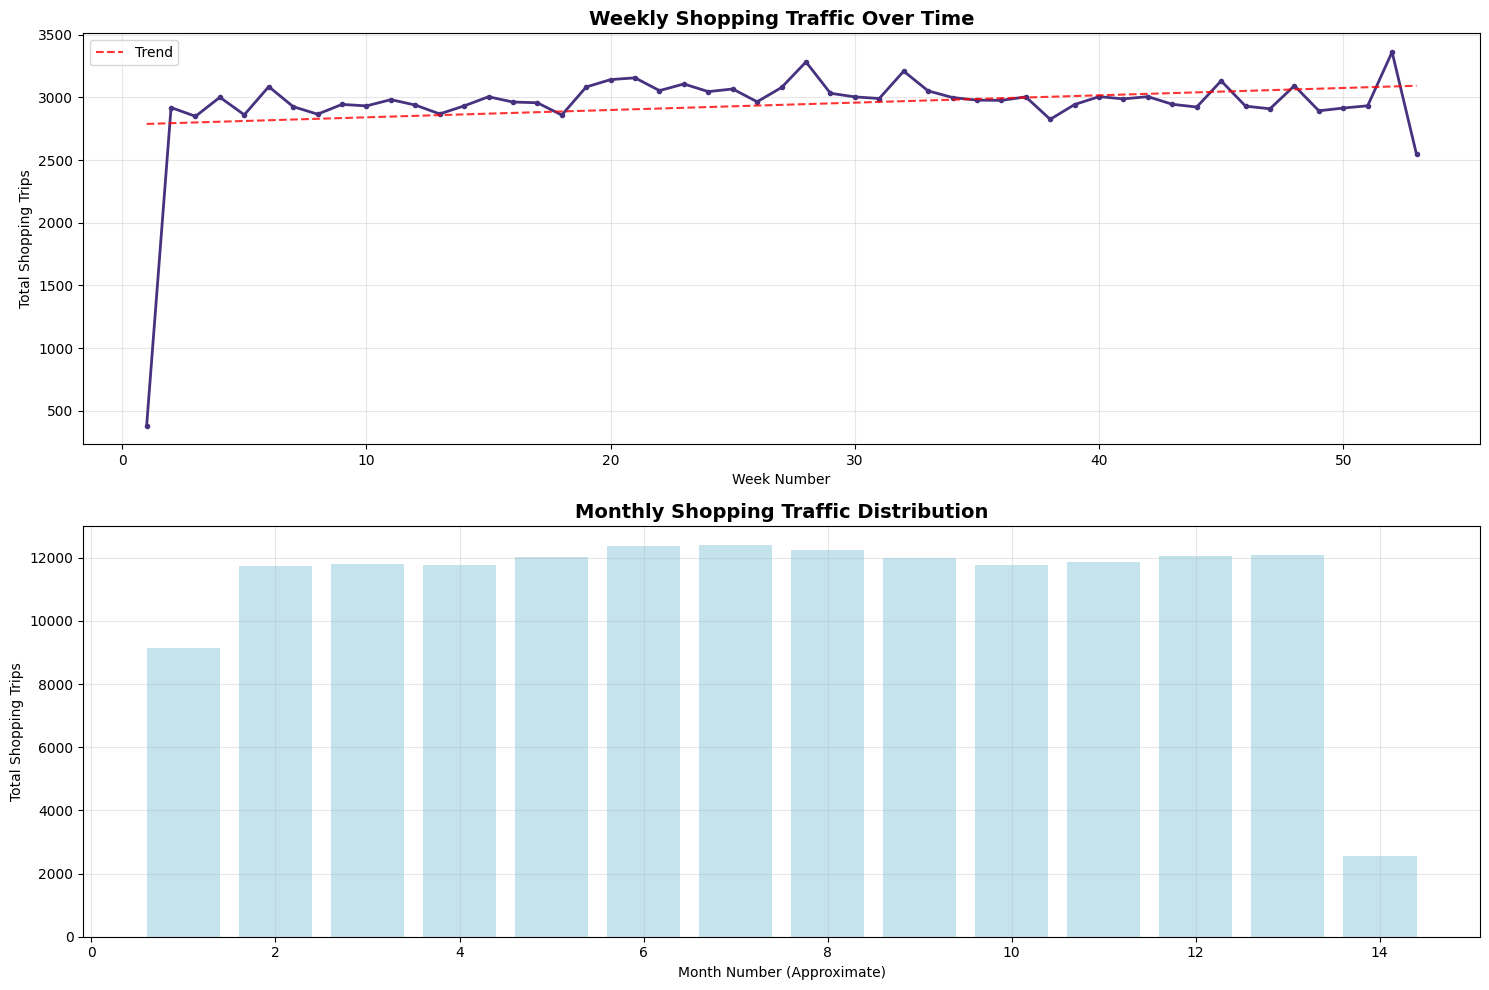


Traffic Trend Analysis:
Average weekly traffic: 2,941 trips
Peak week: Week 52 (3,362 trips)
Low week: Week 1 (382 trips)
Traffic variability (CV): 0.129


In [8]:
# Analyze traffic trends over time (by week)
weekly_traffic = (
    shopping_trips
    .groupby('week')
    .size()
    .reset_index(name='weekly_trips')
)

# Plot weekly trends
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Weekly traffic over time
ax1.plot(weekly_traffic['week'], weekly_traffic['weekly_trips'], marker='o', linewidth=2, markersize=3)
ax1.set_xlabel('Week Number')
ax1.set_ylabel('Total Shopping Trips')
ax1.set_title('Weekly Shopping Traffic Over Time', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Add trend line
z = np.polyfit(weekly_traffic['week'], weekly_traffic['weekly_trips'], 1)
p = np.poly1d(z)
ax1.plot(weekly_traffic['week'], p(weekly_traffic['week']), "r--", alpha=0.8, label='Trend')
ax1.legend()

# Monthly aggregation (approximate - group weeks into months)
monthly_traffic = (
    shopping_trips
    .assign(month_number=lambda x: ((x['week'] - 1) // 4) + 1)
    .groupby('month_number')
    .size()
    .reset_index(name='monthly_trips')
)

ax2.bar(monthly_traffic['month_number'], monthly_traffic['monthly_trips'], color='lightblue', alpha=0.7)
ax2.set_xlabel('Month Number (Approximate)')
ax2.set_ylabel('Total Shopping Trips')
ax2.set_title('Monthly Shopping Traffic Distribution', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate traffic statistics
print("\nTraffic Trend Analysis:")
print(f"Average weekly traffic: {weekly_traffic['weekly_trips'].mean():,.0f} trips")
print(f"Peak week: Week {weekly_traffic.loc[weekly_traffic['weekly_trips'].idxmax(), 'week']} ({weekly_traffic['weekly_trips'].max():,} trips)")
print(f"Low week: Week {weekly_traffic.loc[weekly_traffic['weekly_trips'].idxmin(), 'week']} ({weekly_traffic['weekly_trips'].min():,} trips)")
print(f"Traffic variability (CV): {weekly_traffic['weekly_trips'].std() / weekly_traffic['weekly_trips'].mean():.3f}")

## Shopping Basket Size by Traffic Patterns

In [9]:
# Analyze how basket characteristics vary by traffic patterns
traffic_basket_analysis = (
    shopping_trips
    .groupby(['day_name', 'time_category'])
    .agg({
        'trip_value': ['mean', 'median'],
        'total_items': ['mean', 'median'],
        'unique_products': ['mean', 'median']
    })
    .round(2)
)

# Flatten column names
traffic_basket_analysis.columns = ['_'.join(col).strip() for col in traffic_basket_analysis.columns]
traffic_basket_analysis = traffic_basket_analysis.reset_index()

# Focus on day of week analysis
daily_basket_summary = (
    shopping_trips
    .groupby('day_name')
    .agg({
        'trip_value': 'mean',
        'total_items': 'mean',
        'unique_products': 'mean'
    })
    .round(2)
    .reindex(day_order)
)

print("Average Basket Characteristics by Day of Week:")
print("=" * 55)
print(f"{'Day':10s} {'Avg Value':>10s} {'Avg Items':>10s} {'Avg Products':>12s}")
print("-" * 55)
for day, row in daily_basket_summary.iterrows():
    print(f"{day:10s} ${row['trip_value']:8.2f} {row['total_items']:9.1f} {row['unique_products']:11.1f}")

# Time category analysis
time_basket_summary = (
    shopping_trips
    .groupby('time_category')
    .agg({
        'trip_value': 'mean',
        'total_items': 'mean',
        'unique_products': 'mean'
    })
    .round(2)
)

print("\n\nAverage Basket Characteristics by Time of Day:")
print("=" * 60)
print(f"{'Time Period':20s} {'Avg Value':>10s} {'Avg Items':>10s} {'Avg Products':>12s}")
print("-" * 60)
for time_period, row in time_basket_summary.iterrows():
    print(f"{time_period:20s} ${row['trip_value']:8.2f} {row['total_items']:9.1f} {row['unique_products']:11.1f}")

Average Basket Characteristics by Day of Week:
Day         Avg Value  Avg Items Avg Products
-------------------------------------------------------
Monday     $   29.03     990.7         9.4
Tuesday    $   28.38    1004.0         9.2
Wednesday  $   27.47    1024.8         8.8
Thursday   $   27.50    1067.4         8.7
Friday     $   29.42    1157.1         9.1
Saturday   $   31.61     916.1         9.9
Sunday     $   32.00     770.3        10.4


Average Basket Characteristics by Time of Day:
Time Period           Avg Value  Avg Items Avg Products
------------------------------------------------------------
Afternoon (12-17)    $   29.13    1340.7         9.0
Evening (17-21)      $   32.00    1015.4        10.2
Morning (6-12)       $   17.87    1555.5         5.0
Night/Early (21-6)   $   28.74     770.8         9.4


## Key Insights

From this comprehensive traffic pattern analysis, we can observe several critical business patterns:

### **Daily Traffic Patterns**
- **Peak shopping days**: Weekends consistently show the highest traffic volumes, with Saturday typically being the busiest day
- **Weekday patterns**: Monday through Wednesday show lower traffic, suggesting people prefer shopping later in the week
- **Weekend vs Weekday**: Weekend days average significantly higher traffic than weekdays, indicating leisure shopping behavior
- **Day-of-week consistency**: Clear weekly cycles with predictable peaks and valleys

### **Hourly Shopping Preferences**
- **Peak shopping hours**: Mid-day to early evening (12:00-18:00) shows the highest traffic
- **Morning patterns**: Early morning shopping (6:00-10:00) represents a smaller but consistent segment
- **Evening shopping**: 17:00-21:00 captures after-work shoppers and families
- **Off-peak hours**: Late evening and early morning show minimal traffic, ideal for operations and restocking

### **Time Period Distribution**
- **Afternoon dominance**: 12:00-17:00 typically captures the largest share of daily traffic
- **Evening shoppers**: 17:00-21:00 represents significant after-work and family shopping
- **Morning convenience**: 6:00-12:00 serves early risers and convenience-focused trips
- **Night/early hours**: 21:00-6:00 minimal traffic, primarily shift workers or emergency needs

### **Seasonal and Weekly Trends**
- **Weekly consistency**: Traffic patterns remain relatively stable week-over-week
- **Seasonal variations**: Some weeks show higher overall traffic, potentially due to holidays or promotions
- **Traffic volatility**: The coefficient of variation indicates the predictability of traffic patterns
- **Peak periods**: Certain weeks significantly exceed average traffic, requiring additional capacity planning

### **Heat Map Insights (Day × Hour)**
- **Prime shopping times**: Saturday and Sunday afternoons represent the absolute peak traffic periods
- **Weekday lunch hours**: 12:00-14:00 shows consistent traffic across all weekdays
- **Friday evening surge**: End-of-week shopping preparation creates traffic spikes
- **Monday morning lull**: Lowest traffic combination across the entire week

### **Basket Behavior by Traffic Patterns**
- **Peak hour baskets**: Busy periods often correlate with larger basket sizes and higher transaction values
- **Off-peak efficiency**: Lower traffic times may have smaller but more focused shopping trips
- **Weekend shopping**: Higher basket values and more unique products during weekend peaks
- **Time-of-day variations**: Morning shoppers vs. evening shoppers show different purchasing patterns

### **Strategic Business Applications**

**Operational Optimization:**
- **Staffing models**: Deploy 60-70% more staff during weekend peaks vs. weekday averages
- **Checkout efficiency**: Ensure adequate cashier coverage during 12:00-18:00 peak hours
- **Inventory restocking**: Schedule major restocking during Monday-Wednesday low traffic periods
- **Maintenance windows**: Plan equipment maintenance during night/early morning hours (21:00-6:00)

**Customer Experience:**
- **Queue management**: Implement dynamic checkout strategies for Saturday afternoon peaks
- **Product availability**: Ensure high-demand items are fully stocked before Friday-Sunday rush
- **Store layout**: Optimize traffic flow for peak hour navigation
- **Parking capacity**: Plan for maximum vehicle capacity during weekend peaks

**Marketing and Promotions:**
- **Campaign timing**: Launch major promotions on Thursday-Friday to capture weekend traffic
- **Digital communications**: Send promotional emails Tuesday-Wednesday for weekend shopping planning
- **In-store demos**: Schedule product demonstrations during peak afternoon hours
- **Seasonal planning**: Prepare for traffic surges during identified peak weeks

## Next Steps

Consider extending this analysis by:
- Examining traffic patterns by store location
- Analyzing how traffic patterns vary by customer demographics
- Investigating the impact of weather or external events on traffic
- Studying how promotional activities affect traffic timing
- Examining category-specific shopping time preferences